In [34]:
import os
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm

ROOT = './images'
NUM_IMAGES = 200
IMAGE_SIZE = (96, 96)

matplotlib.rcParams['font.size'] = 13
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
def get_image_name_ds():
    names = os.listdir(ROOT)[:NUM_IMAGES]
    name_ds = tf.data.Dataset.from_tensor_slices([os.path.join(ROOT, name) for name in names])
    return name_ds

def load_one_image(name):
    image = tf.io.read_file(name)
    image = tf.image.decode_jpeg(image, 3)
    image = tf.image.resize(image, IMAGE_SIZE, 'nearest') / 255
    return image

def load_data():
    name_ds = get_image_name_ds()
    image_ds = name_ds.map(load_one_image)
    return image_ds

image_ds = load_data()
for image in image_ds.take(1):
    test_image = image

122


(-0.5, 95.5, 95.5, -0.5)

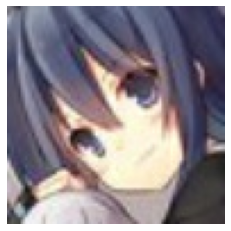

In [36]:
print(len(image_ds))
plt.imshow(test_image)
plt.axis('off')

In [37]:
image_ds = image_ds.cache().shuffle(NUM_IMAGES).batch(20)

In [166]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        eo_size = calc_size_after_conv(IMAGE_SIZE[0], 3, 2, 0)
        self.eo_size = calc_size_after_conv(eo_size, 3, 2, 0) # encoder output size
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.Input(shape=IMAGE_SIZE + (3, )),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.Input(shape=(latent_dim,)),
                tf.keras.layers.Dense(units=self.eo_size*self.eo_size*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(self.eo_size, self.eo_size, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=3, kernel_size=3, strides=1, padding='same'),
            ]
        )

    @tf.function
    def call(self, images, training=False):
        mean, logvar = self.encode(images)
        Z_posterior_dist = tfp.distributions.Normal(mean, tf.exp(0.5 * logvar))
        Z = self.reparameterize(mean, logvar)
        reconstructed_images = self.decode(Z)
        reconstructed_images = tf.clip_by_value(reconstructed_images, 0., 1.)
        return reconstructed_images, Z_posterior_dist

    def encode(self, X):
        mean, logvar = tf.split(self.encoder(X), num_or_size_splits=2, axis=1)
        return mean, logvar

    def decode(self, Z):
        reconstructed_images = self.decoder(Z)
        return reconstructed_images

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return mean + eps * tf.exp(logvar * .5)

def calc_size_after_conv(layer_size, kernel_size, stride, p):
    size = tf.math.ceil((layer_size + 2 * p - kernel_size) / stride) + 1.
    return tf.cast(size, tf.int32).numpy()

In [177]:
@tf.function
def train_step(model, images, optimizer, weight=0.0001):
    with tf.GradientTape() as tape:
        loss = calc_loss(model, images, weight)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def calc_loss(model, images, weight=0.0001):
    reconstructed_images, Z_posterior_dist = model(images, training=True)
    reconstruction_loss = tf.reduce_mean((images - reconstructed_images)**2.)
    kl_loss = tf.reduce_mean(kl_divergence(Z_posterior_dist))
    loss = reconstruction_loss + weight * kl_loss
    return loss

def kl_divergence(Z_posterior_dist):
    loc = tf.zeros(Z_posterior_dist.loc.shape)
    scale = tf.ones(Z_posterior_dist.scale.shape)
    standard_dist = tfp.distributions.Normal(loc, scale)
    return tfp.distributions.kl_divergence(standard_dist, Z_posterior_dist)

vae = VAE(latent_dim=20)

100%|██████████| 7/7 [00:01<00:00,  4.64it/s]


epoch: 1 loss: 0.24354287981987


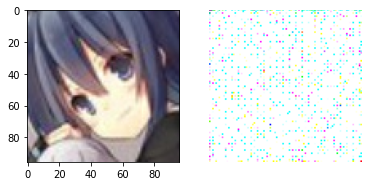

100%|██████████| 7/7 [00:00<00:00, 62.55it/s]


epoch: 2 loss: 0.1228293627500534


100%|██████████| 7/7 [00:00<00:00, 67.00it/s]


epoch: 3 loss: 0.06438419967889786


100%|██████████| 7/7 [00:00<00:00, 81.65it/s]


epoch: 4 loss: 0.05864688381552696


100%|██████████| 7/7 [00:00<00:00, 89.80it/s]


epoch: 5 loss: 0.06326620280742645


100%|██████████| 7/7 [00:00<00:00, 101.59it/s]


epoch: 6 loss: 0.06009611114859581


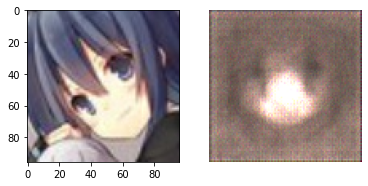

100%|██████████| 7/7 [00:00<00:00, 103.80it/s]


epoch: 7 loss: 0.06095685437321663


100%|██████████| 7/7 [00:00<00:00, 99.15it/s]


epoch: 8 loss: 0.07278423011302948


100%|██████████| 7/7 [00:00<00:00, 102.59it/s]


epoch: 9 loss: 0.05804689973592758


100%|██████████| 7/7 [00:00<00:00, 99.68it/s]


epoch: 10 loss: 0.04046238958835602


100%|██████████| 7/7 [00:00<00:00, 104.59it/s]


epoch: 11 loss: 0.07028696686029434


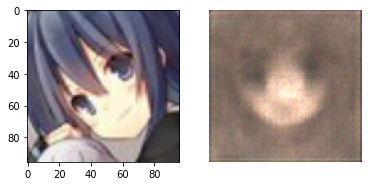

100%|██████████| 7/7 [00:00<00:00, 104.68it/s]


epoch: 12 loss: 0.04986468330025673


100%|██████████| 7/7 [00:00<00:00, 105.96it/s]


epoch: 13 loss: 0.05079379305243492


100%|██████████| 7/7 [00:00<00:00, 106.58it/s]


epoch: 14 loss: 0.050145313143730164


100%|██████████| 7/7 [00:00<00:00, 102.20it/s]


epoch: 15 loss: 0.06634058803319931


100%|██████████| 7/7 [00:00<00:00, 98.41it/s]


epoch: 16 loss: 0.06864279508590698


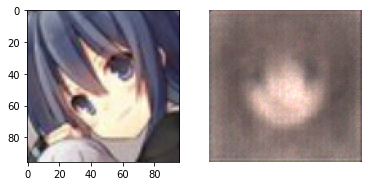

100%|██████████| 7/7 [00:00<00:00, 107.13it/s]


epoch: 17 loss: 0.03755556792020798


100%|██████████| 7/7 [00:00<00:00, 103.33it/s]


epoch: 18 loss: 0.036817293614149094


100%|██████████| 7/7 [00:00<00:00, 106.73it/s]


epoch: 19 loss: 0.033631112426519394


100%|██████████| 7/7 [00:00<00:00, 103.77it/s]


epoch: 20 loss: 0.044733043760061264


100%|██████████| 7/7 [00:00<00:00, 106.12it/s]


epoch: 21 loss: 0.06159671023488045


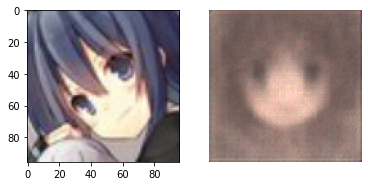

100%|██████████| 7/7 [00:00<00:00, 101.06it/s]


epoch: 22 loss: 0.050825707614421844


100%|██████████| 7/7 [00:00<00:00, 102.12it/s]


epoch: 23 loss: 0.03562070056796074


100%|██████████| 7/7 [00:00<00:00, 99.45it/s]


epoch: 24 loss: 0.02683238871395588


100%|██████████| 7/7 [00:00<00:00, 104.93it/s]


epoch: 25 loss: 0.048823416233062744


100%|██████████| 7/7 [00:00<00:00, 96.28it/s]


epoch: 26 loss: 0.04651302844285965


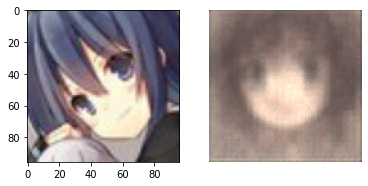

100%|██████████| 7/7 [00:00<00:00, 103.31it/s]


epoch: 27 loss: 0.04625070095062256


100%|██████████| 7/7 [00:00<00:00, 102.30it/s]


epoch: 28 loss: 0.038209520280361176


100%|██████████| 7/7 [00:00<00:00, 102.75it/s]


epoch: 29 loss: 0.04623245820403099


100%|██████████| 7/7 [00:00<00:00, 106.23it/s]


epoch: 30 loss: 0.041408564895391464


100%|██████████| 7/7 [00:00<00:00, 96.45it/s]


epoch: 31 loss: 0.029354900121688843


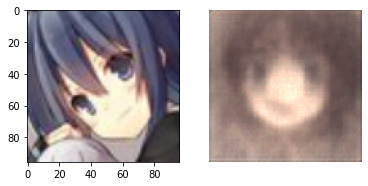

100%|██████████| 7/7 [00:00<00:00, 102.43it/s]


epoch: 32 loss: 0.03638843446969986


100%|██████████| 7/7 [00:00<00:00, 95.92it/s]


epoch: 33 loss: 0.04043760150671005


100%|██████████| 7/7 [00:00<00:00, 98.82it/s]


epoch: 34 loss: 0.03941882401704788


100%|██████████| 7/7 [00:00<00:00, 102.78it/s]


epoch: 35 loss: 0.032944388687610626


100%|██████████| 7/7 [00:00<00:00, 103.74it/s]


epoch: 36 loss: 0.0392582081258297


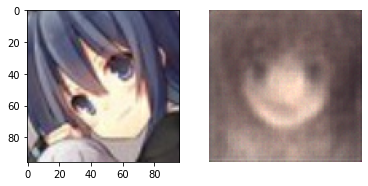

100%|██████████| 7/7 [00:00<00:00, 99.81it/s]


epoch: 37 loss: 0.02894837222993374


100%|██████████| 7/7 [00:00<00:00, 99.78it/s]


epoch: 38 loss: 0.03710976243019104


100%|██████████| 7/7 [00:00<00:00, 95.94it/s]


epoch: 39 loss: 0.03984148055315018


100%|██████████| 7/7 [00:00<00:00, 93.22it/s]


epoch: 40 loss: 0.03293992578983307


100%|██████████| 7/7 [00:00<00:00, 96.51it/s]


epoch: 41 loss: 0.03900020569562912


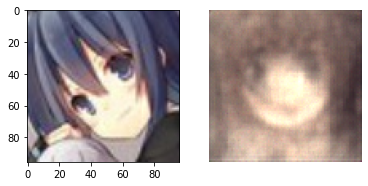

100%|██████████| 7/7 [00:00<00:00, 105.29it/s]


epoch: 42 loss: 0.03869251161813736


100%|██████████| 7/7 [00:00<00:00, 99.49it/s]


epoch: 43 loss: 0.021558493375778198


100%|██████████| 7/7 [00:00<00:00, 101.21it/s]


epoch: 44 loss: 0.032644741237163544


100%|██████████| 7/7 [00:00<00:00, 99.66it/s]


epoch: 45 loss: 0.043265800923109055


100%|██████████| 7/7 [00:00<00:00, 95.63it/s]


epoch: 46 loss: 0.0293369572609663


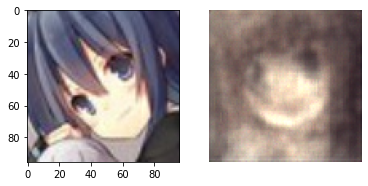

100%|██████████| 7/7 [00:00<00:00, 109.19it/s]


epoch: 47 loss: 0.030437041074037552


100%|██████████| 7/7 [00:00<00:00, 102.65it/s]


epoch: 48 loss: 0.026355618610978127


100%|██████████| 7/7 [00:00<00:00, 92.18it/s]


epoch: 49 loss: 0.0374031625688076


100%|██████████| 7/7 [00:00<00:00, 95.02it/s]

epoch: 50 loss: 0.018667301163077354


In [178]:
epochs = 50
optimizer = tf.keras.optimizers.Adam(0.001)
for e in range(1, epochs + 1):
    for images in tqdm(image_ds):
        loss = train_step(vae, images, optimizer, weight=0.00001)
    print(f'epoch: {e}', f'loss: {loss}')
    if (e - 1) % 5 == 0:
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        ax1.imshow(test_image)
        ax2.imshow(vae(test_image[tf.newaxis, ...])[0][0])
        plt.axis('off')
        plt.show()

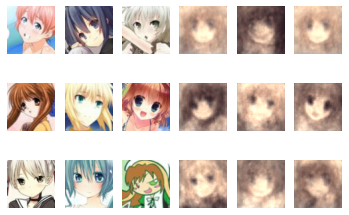

In [179]:
for i in image_ds.unbatch().batch(9).take(1):
    images = i
    images_recon = vae(i)[0]

fig = plt.figure()
for i in range(18):
    ax = fig.add_subplot(3, 6, i + 1)
    if i % 6 < 3:
        ax.imshow(images[i - i // 6 * 3, ...])
    else:
        ax.imshow(images_recon[i - (i // 6 + 1) * 3, ...])
    ax.set_axis_off()